In [1]:
import torch
import torch.nn as nn  #神经网络工具箱torch.nn
import torch.nn.functional as F  #神经网络函数torch.nn.functional
import numpy as np
import sys
import math
import os

https://github.com/chenyuAndroid/deep-learning-examples/tree/master/glove/model

In [2]:
pathout="./gloveout"
if not os.path.exists(pathout):os.makedirs(pathout)

In [3]:
import torch
import torch.utils.data as tud  #Pytorch读取训练集需要用到torch.utils.data类

from collections import Counter
from sklearn.metrics.pairwise import  cosine_similarity

import pandas as pd
import numpy as np
import scipy

import time
import math
import random
import sys
import matplotlib.pyplot as plt

# from WordEmbeddingDataset import WordEmbeddingDataset
# from GloveModel import GloveModel

In [4]:
import torch.utils.data as tud
import torch

In [5]:
EMBEDDING_SIZE = 50
MAX_VOCAB_SIZE = 2000
WINDOW_SIZE = 5

NUM_EPOCHS = 10
BATCH_SIZE = 10
LEARNING_RATE = 0.05

TEXT_SIZE = 20000000
LOG_FILE = "{}/glove-{}.log".format(pathout,EMBEDDING_SIZE)
WEIGHT_FILE = "{}/glove-{}.th".format(pathout,EMBEDDING_SIZE)


In [6]:
class WordEmbeddingDataset(tud.Dataset):
    def __init__(self, co_matrix, weight_matrix):
        self.co_matrix = co_matrix
        self.weight_matrix = weight_matrix
        self.train_set = []

        for i in range(self.weight_matrix.shape[0]):
            for j in range(self.weight_matrix.shape[1]):
                if weight_matrix[i][j] != 0:
                    # 这里对权重进行了筛选，去掉权重为0的项
                    # 因为共现次数为0会导致log(X)变成nan
                    self.train_set.append((i, j))

    def __len__(self):
        '''
        必须重写的方法
        :return: 返回训练集的大小
        '''
        return len(self.train_set)

    def __getitem__(self, index):
        '''
        必须重写的方法
        :param index:样本索引
        :return: 返回一个样本
        '''
        (i, j) = self.train_set[index]
        return i, j, torch.tensor(self.co_matrix[i][j], dtype=torch.float), self.weight_matrix[i][j]

In [7]:
class GloveModel(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size

        #声明v和w为Embedding向量
        self.v = nn.Embedding(vocab_size, embed_size)
        self.w = nn.Embedding(vocab_size, embed_size)
        self.biasv = nn.Embedding(vocab_size, 1)
        self.biasw = nn.Embedding(vocab_size, 1)

        #随机初始化参数
        initrange = 0.5 / self.embed_size
        self.v.weight.data.uniform_(-initrange, initrange)
        self.w.weight.data.uniform_(-initrange, initrange)

    def forward(self, i, j, co_occur, weight):
        vi = self.v(i)
        wj = self.w(j)
        bi = self.biasv(i)
        bj = self.biasw(j)

        similarity = torch.mul(vi, wj)
        similarity = torch.sum(similarity, dim=1)

        loss = similarity + bi + bj - torch.log(co_occur)
        loss = 0.5 * weight * loss * loss

        return loss.sum().mean()

    def gloveMatrix(self):
        '''
        获得词向量，这里把两个向量相加作为最后的词向量
        :return:
        '''
        return self.v.weight.data.numpy() + self.w.weight.data.numpy()

In [8]:
def getCorpus(filetype, size):
    if filetype == 'dev':
        filepath = '/kaggle/input/training-data-for-word2vec/text8/text8.dev.txt'
    elif filetype == 'test':
        filepath = '/kaggle/input/training-data-for-word2vec/text8/text8.test.txt'
    else:
        filepath = '/kaggle/input/training-data-for-word2vec/text8/text8.train.txt'

    with open(filepath, "r") as f:
        text = f.read()
        text = text.lower().split()
        text = text[: min(len(text), size)]
        vocab_dict = dict(Counter(text).most_common(MAX_VOCAB_SIZE - 1))
        vocab_dict['<unk>'] = len(text) - sum(list(vocab_dict.values()))
        idx_to_word = list(vocab_dict.keys())
        word_to_idx = {word:ind for ind, word in enumerate(idx_to_word)}
        word_counts = np.array(list(vocab_dict.values()), dtype=np.float32)
        word_freqs = word_counts / sum(word_counts)
        print("Words list length:{}".format(len(text)))
        print("Vocab size:{}".format(len(idx_to_word)))
    return text, idx_to_word, word_to_idx, word_counts, word_freqs

def buildCooccuranceMatrix(text, word_to_idx):
    vocab_size = len(word_to_idx)
    maxlength = len(text)
    text_ids = [word_to_idx.get(word, word_to_idx["<unk>"]) for word in text]
    cooccurance_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    print("Co-Matrix consumed mem:%.2fMB" % (sys.getsizeof(cooccurance_matrix)/(1024*1024)))
    for i, center_word_id in enumerate(text_ids):
        window_indices = list(range(i - WINDOW_SIZE, i)) + list(range(i + 1, i + WINDOW_SIZE + 1))
        window_indices = [i % maxlength for i in window_indices]
        window_word_ids = [text_ids[index] for index in window_indices]
        for context_word_id in window_word_ids:
            cooccurance_matrix[center_word_id][context_word_id] += 1
        if (i+1) % 1000000 == 0:
            print(">>>>> Process %dth word" % (i+1))
    print(">>>>> Build co-occurance matrix completed.")
    return cooccurance_matrix

def buildWeightMatrix(co_matrix):
    xmax = 100.0
    weight_matrix = np.zeros_like(co_matrix, dtype=np.float32)
    print("Weight-Matrix consumed mem:%.2fMB" % (sys.getsizeof(weight_matrix) / (1024 * 1024)))
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            weight_matrix[i][j] = math.pow(co_matrix[i][j] / xmax, 0.75) if co_matrix[i][j] < xmax else 1
        if (i+1) % 1000 == 0:
            print(">>>>> Process %dth weight" % (i+1))
    print(">>>>> Build weight matrix completed.")
    return weight_matrix

def find_nearest(word, embedding_weights):
    index = word_to_idx[word]
    embedding = embedding_weights[index]
    cos_dis = np.array([scipy.spatial.distance.cosine(e, embedding) for e in embedding_weights])
    return [idx_to_word[i] for i in cos_dis.argsort()[:10]]

scipy.spatial.distance.cosine 的用法

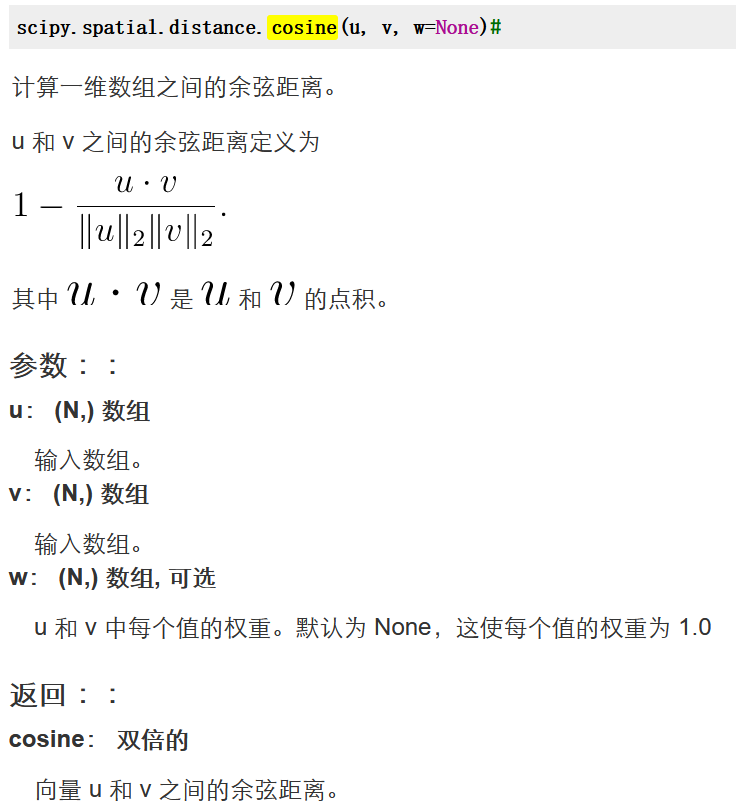

In [9]:
def asMinutes(s):
    h = math.floor(s / 3600)
    s = s - h * 3600
    m = math.floor(s / 60)
    s -= m * 60
    return '%dh %dm %ds' % (h, m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def loadModel():
    path = WEIGHT_FILE
    model = GloveModel(MAX_VOCAB_SIZE, EMBEDDING_SIZE)
    model.load_state_dict(torch.load(path))
    return model

def findRelationshipVector(word1, word2, word3):
    word1_idx = word_to_idx[word1]
    word2_idx = word_to_idx[word2]
    word3_idx = word_to_idx[word3]
    embedding = glove_matrix[word2_idx] - glove_matrix[word1_idx] + glove_matrix[word3_idx]
    cos_dis = np.array([scipy.spatial.distance.cosine(e, embedding) for e in glove_matrix])
    for i in cos_dis.argsort()[:5]:
        print("{} to {} as {} to {}".format(word1, word2, word3, idx_to_word[i]))

def mainrun():
    
    start = time.time()
    for epoch in range(epochs):
        loss_print_avg = 0
        iteration = iters_per_epoch * epoch
        for i, j, co_occur, weight in dataloader:
            iteration += 1
            optimizer.zero_grad()   #每一批样本训练前重置缓存的梯度
            loss = model(i, j, co_occur, weight)    #前向传播
            loss.backward()     #反向传播
            optimizer.step()    #更新梯度
            loss_print_avg += loss.item()

            if iteration % print_every == 0:
                time_desc = timeSince(start, iteration / total_iterations)
                iter_percent = iteration / total_iterations * 100
                loss_avg = loss_print_avg / print_every
                loss_print_avg = 0
                print("LOG_FILE:",LOG_FILE)
                with open(LOG_FILE, "a") as fout:
                    fout.write("epoch: %d, iter: %d (%.4f%%), loss: %.5f, %s\n" %
                               (epoch, iteration, iter_percent, loss_avg, time_desc))
                print("epoch: %d, iter: %d/%d (%.4f%%), loss: %.5f, %s" %
                      (epoch, iteration, total_iterations, iter_percent, loss_avg, time_desc))
            if iteration % save_every == 0:
                torch.save(model.state_dict(), WEIGHT_FILE)
    torch.save(model.state_dict(), WEIGHT_FILE)

#     glove_matrix = model.gloveMatrix()
    for word in ["good", "one", "green", "like", "america", "queen", "better", "paris", "work", "computer", "language"]:
        print(word, find_nearest(word, glove_matrix))
    findRelationshipVector('man', 'king', 'woman')
    findRelationshipVector('america', 'washington', 'france')
    findRelationshipVector('good', 'better', 'little')

    #数据降维以及可视化
    candidate_words = ['one','two','three','four','five','six','seven','eight','night','ten','color','green','blue','red','black',
                       'man','woman','king','queen','wife','son','daughter','brown','zero','computer','hardware','software','system','program',
                       'america','china','france','washington','good','better','bad']
    candidate_indexes = [word_to_idx[word] for word in candidate_words]
    choosen_indexes = candidate_indexes
    choosen_vectors = [glove_matrix[index] for index in choosen_indexes]

    U, S, VH = np.linalg.svd(choosen_vectors, full_matrices=False)
    for i in range(len(choosen_indexes)):
        plt.text(U[i, 0], U[i, 1], idx_to_word[choosen_indexes[i]])

    coordinate = U[:, 0:2]
    plt.xlim((np.min(coordinate[:, 0]) - 0.1, np.max(coordinate[:, 0]) + 0.1))
    plt.ylim((np.min(coordinate[:, 1]) - 0.1, np.max(coordinate[:, 1]) + 0.1))
    plt.show()

In [13]:
glove_matrix = model.gloveMatrix()

在Numpy中，我们可以使用np.linalg.svd()函数对矩阵进行SVD分解。该函数的定义如下：

            numpy.linalg.svd(a, full_matrices=True, compute_uv=True)

其中a为要分解的矩阵，full_matrices则指定是否构造完全矩阵（即是否构造出与分解矩阵具有同样形状的U和V完整矩阵，默认为True），compute_uv则指定是否返回左右奇异向量，默认为True。

In [10]:
text, idx_to_word, word_to_idx, word_counts, word_freqs = getCorpus('train', size=TEXT_SIZE)    #加载语料及预处理
co_matrix = buildCooccuranceMatrix(text, word_to_idx)    #构建共现矩阵
weight_matrix = buildWeightMatrix(co_matrix)             #构建权重矩阵
dataset = WordEmbeddingDataset(co_matrix, weight_matrix) #创建dataset
dataloader = tud.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
model = GloveModel(MAX_VOCAB_SIZE, EMBEDDING_SIZE) #创建模型
#model = loadModel()
optimizer = torch.optim.Adagrad(model.parameters(), lr=LEARNING_RATE) #选择Adagrad优化器


print_every = 10000
save_every = 50000
epochs = NUM_EPOCHS
iters_per_epoch = int(dataset.__len__() / BATCH_SIZE)
total_iterations = iters_per_epoch * epochs
print("Iterations: %d per one epoch, Total iterations: %d " % (iters_per_epoch, total_iterations))


Words list length:15313011
Vocab size:2000
Co-Matrix consumed mem:15.26MB
>>>>> Process 1000000th word
>>>>> Process 2000000th word
>>>>> Process 3000000th word
>>>>> Process 4000000th word
>>>>> Process 5000000th word
>>>>> Process 6000000th word
>>>>> Process 7000000th word
>>>>> Process 8000000th word
>>>>> Process 9000000th word
>>>>> Process 10000000th word
>>>>> Process 11000000th word
>>>>> Process 12000000th word
>>>>> Process 13000000th word
>>>>> Process 14000000th word
>>>>> Process 15000000th word
>>>>> Build co-occurance matrix completed.
Weight-Matrix consumed mem:15.26MB
>>>>> Process 1000th weight
>>>>> Process 2000th weight
>>>>> Build weight matrix completed.
Iterations: 265854 per one epoch, Total iterations: 2658540 


In [15]:
# word_to_idx[:5]

In [12]:
mainrun()

LOG_FILE: ./gloveout/glove-50.log
epoch: 0, iter: 10000/2658540 (0.3761%), loss: 89.40564, 0h 0m 14s (- 1h 5m 52s)
LOG_FILE: ./gloveout/glove-50.log
epoch: 0, iter: 20000/2658540 (0.7523%), loss: 48.40221, 0h 0m 27s (- 1h 1m 10s)
LOG_FILE: ./gloveout/glove-50.log
epoch: 0, iter: 30000/2658540 (1.1284%), loss: 27.01526, 0h 0m 40s (- 0h 59m 5s)
LOG_FILE: ./gloveout/glove-50.log
epoch: 0, iter: 40000/2658540 (1.5046%), loss: 20.22761, 0h 0m 53s (- 0h 58m 20s)
LOG_FILE: ./gloveout/glove-50.log
epoch: 0, iter: 50000/2658540 (1.8807%), loss: 17.47708, 0h 1m 7s (- 0h 58m 20s)
LOG_FILE: ./gloveout/glove-50.log
epoch: 0, iter: 60000/2658540 (2.2569%), loss: 15.64037, 0h 1m 20s (- 0h 57m 48s)
LOG_FILE: ./gloveout/glove-50.log
epoch: 0, iter: 70000/2658540 (2.6330%), loss: 14.79422, 0h 1m 32s (- 0h 57m 10s)
LOG_FILE: ./gloveout/glove-50.log
epoch: 0, iter: 80000/2658540 (3.0092%), loss: 13.53706, 0h 1m 46s (- 0h 56m 58s)
LOG_FILE: ./gloveout/glove-50.log
epoch: 0, iter: 90000/2658540 (3.3853%), l

NameError: name 'glove_matrix' is not defined